In [1]:
%matplotlib inline
from matplotlib import style
#style.use('seaborn')
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

Last Date:  2017-08-23


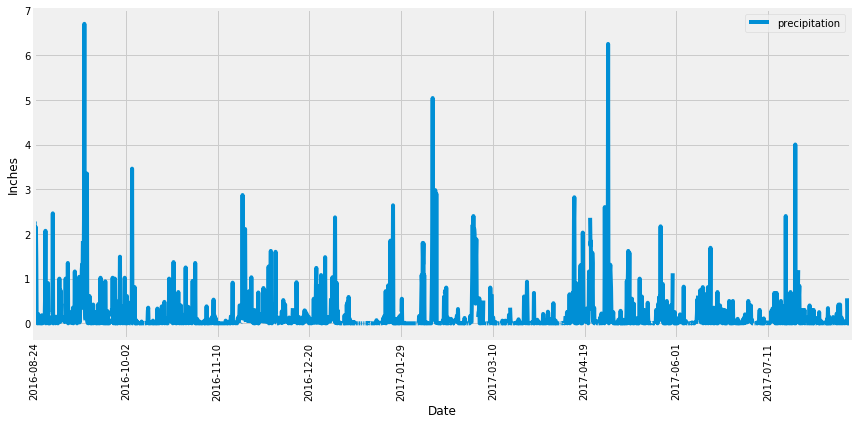

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel=[Measurement.date,Measurement.prcp]

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date=dt.date(2017, 8, 23)
print("Last Date: ", last_date)
first_date = last_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precip = session.query(*sel).\
    filter(Measurement.date > first_date).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip, columns=['Date', 'precipitation'])

df.set_index(df['Date'], inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

df.plot('Date','precipitation',figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?

session.query(func.count(Measurement.station.distinct())).all()


[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel2=[Measurement.station,func.count(Measurement.station)]

session.query(*sel2).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel3=[Measurement.station,func.min(Measurement.tobs),\
       func.max(Measurement.tobs),\
       func.avg(Measurement.tobs)]
session.query(*sel3).\
            group_by(Measurement.station).\
            filter(Measurement.station=='USC00519281').all()




[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [17]:
# Choose the station with the highest number of temperature observations.
station_id='USC00519281'


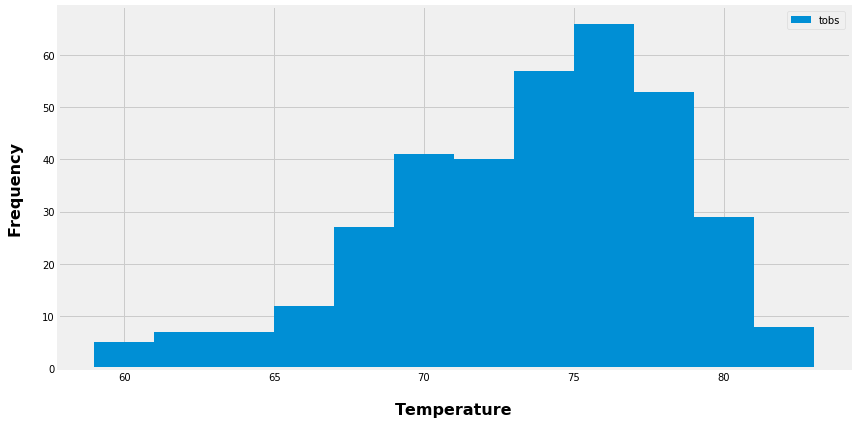

In [18]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
topT_station=session.query(Measurement.tobs).\
            filter(Measurement.station==station_id).\
            filter(Measurement.date >= first_date).\
            filter(Measurement.date < last_date).all()

# Plot the Results in a Matplotlib bar chart
topT_df = pd.DataFrame(topT_station, columns=['tobs'])

hist = topT_df.plot.hist(bins=12,figsize=(12,6))

# Set x-axis label
hist.set_xlabel("Temperature", labelpad=20, weight='bold', size=16)

# Set y-axis label
hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=16)

plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    tobs = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    # Create a dictionary from the row data and append to a list of all sttaions
    temp_dict = {}
    for TMIN,TAVE,TMAX in tobs:
        temp_dict["Min Temp"] = TMIN
        temp_dict["Average Temp"] = TAVE
        temp_dict["Max Temp"]= TMAX
    
    return(temp_dict)

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

{'Min Temp': 62.0, 'Average Temp': 69.57142857142857, 'Max Temp': 74.0}


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date=dt.date(2017, 12, 11)- dt.timedelta(days=365)
end_date=dt.date(2017, 12, 29)- dt.timedelta(days=365)

temp_dict=calc_temps(start_date, end_date)
temp_dict

{'Min Temp': 60.0, 'Average Temp': 71.28455284552845, 'Max Temp': 78.0}

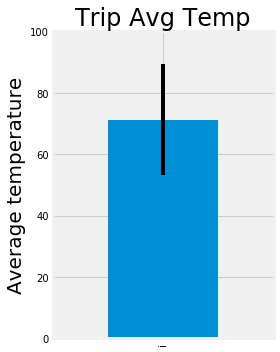

In [58]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_df=pd.DataFrame(temp_dict,index=['i',])
diff=temp_df['Max Temp'][0]-temp_df['Min Temp'][0]
T_avg=temp_df['Average Temp']


T_avg.plot(kind='bar', yerr=diff,figsize=(4,5),)
plt.title("Trip Avg Temp", fontsize=24)
plt.ylabel("Average temperature", fontsize=20)
plt.ylim(0,100)
plt.tight_layout()
plt.show()


In [77]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_prcp(start_date, end_date):
    """PMIN, PAVE, and PMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        PMIN, PAVE, and PMAX
    """
    
    sel4=[func.sum(Measurement.prcp),Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
    
    prcps = session.query(*sel4).\
        group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).filter(Measurement.station==Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).all()
    
    # Create a dictionary from the row data and append to a list of all sttaions
    prcp_dict = []
    for s,sid, name, lat,lng,elev in prcps:
        p_dict={}
        p_dict["Station"] = sid
        p_dict["Name"] = name
        p_dict["Prcp Sum"] =s   
        p_dict["Lat"]= lat
        p_dict["Lng"]= lng
        p_dict["Elevation"]= elev
        prcp_dict.append(p_dict)
    
    
    return (prcp_dict)

# function usage example
prcps1=calc_prcp('2012-02-28', '2012-03-05')

prcps1

[{'Station': 'USC00519281',
  'Name': 'WAIHEE 837.5, HI US',
  'Prcp Sum': 11.08,
  'Lat': 21.45167,
  'Lng': -157.84888999999998,
  'Elevation': 32.9},
 {'Station': 'USC00516128',
  'Name': 'MANOA LYON ARBO 785.2, HI US',
  'Prcp Sum': 10.32,
  'Lat': 21.3331,
  'Lng': -157.8025,
  'Elevation': 152.4},
 {'Station': 'USC00513117',
  'Name': 'KANEOHE 838.1, HI US',
  'Prcp Sum': 5.79,
  'Lat': 21.4234,
  'Lng': -157.8015,
  'Elevation': 14.6},
 {'Station': 'USC00518838',
  'Name': 'UPPER WAHIAWA 874.3, HI US',
  'Prcp Sum': 3.8400000000000003,
  'Lat': 21.4992,
  'Lng': -158.0111,
  'Elevation': 306.6},
 {'Station': 'USC00519523',
  'Name': 'WAIMANALO EXPERIMENTAL FARM, HI US',
  'Prcp Sum': 2.92,
  'Lat': 21.33556,
  'Lng': -157.71139,
  'Elevation': 19.5},
 {'Station': 'USC00519397',
  'Name': 'WAIKIKI 717.2, HI US',
  'Prcp Sum': 1.1800000000000002,
  'Lat': 21.2716,
  'Lng': -157.8168,
  'Elevation': 3.0},
 {'Station': 'USC00511918',
  'Name': 'HONOLULU OBSERVATORY 702.2, HI US',
  

In [72]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [83]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date=dt.date(2017, 12, 11)
end_date=dt.date(2017, 12, 29)

# Use the start and end date to create a range of dates
trip_dates=pd.date_range(start_date,end_date)

# Stip off the year and save a list of %m-%d strings
trip_dfmt=trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
norm_list=[]
for date in trip_dfmt:
    norm_list.append(*daily_normals(date))
norm_list

[(64.0, 72.38775510204081, 78.0),
 (64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0),
 (65.0, 71.18, 78.0),
 (62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0),
 (67.0, 71.1304347826087, 77.0),
 (61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0)]

In [105]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norm_df=pd.DataFrame(norm_list,columns=['Tmin','Tavg','Tmax'])
norm_df['Date']=trip_dates
norm_df.set_index(norm_df['Date'])
norm_df

,Tmin,Tavg,Tmax,Date
0,64.0,72.387755,78.0,2017-12-11
1,64.0,70.882353,79.0,2017-12-12
2,65.0,70.942308,80.0,2017-12-13
3,65.0,71.180000,78.0,2017-12-14
4,62.0,71.340000,79.0,2017-12-15
5,60.0,69.622642,82.0,2017-12-16
6,63.0,70.640000,77.0,2017-12-17
7,63.0,71.280000,77.0,2017-12-18
8,67.0,72.000000,78.0,2017-12-19
9,65.0,72.913043,81.0,2017-12-20


Text(0, 0.5, 'Temperature')

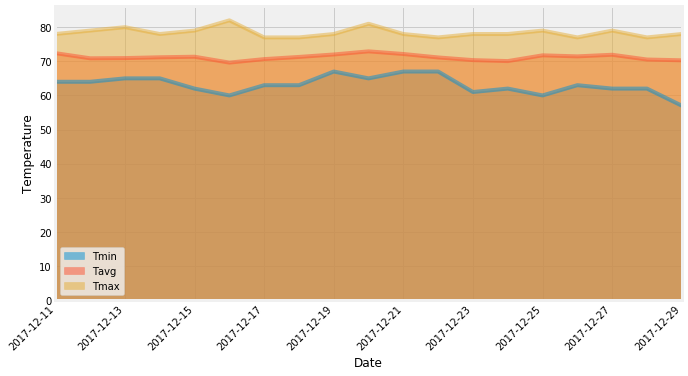

In [115]:
# Plot the daily normals as an area plot with `stacked=False`
norm_df.plot.area(stacked=False,x='Date',x_compat=True,figsize=(10,6),rot=45)

plt.ylabel('Temperature')
